## Here's the code for the final models and nothing else!!
Try to keep tidy so it makes sense!!!

-----------------------------------------------------------------
### 1. Load data 

In [10]:
#Load packages
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Load data and define sharpe function to evaluate the models: 
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()

r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')

#divide by 100 because it was already in % -> we dont want that here!
#then divide by 252 since its on a yearly basis but everything else is on a daily basis
#(252 ~ number of us trading days a year)
r_rf_df['daily_rf'] = r_rf_df['rf_rate']/(100*252)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
#r_rf_df.set_index('Date', inplace=True)
r_rf_df.head()

portfolio_df = pd.merge(portfolio_df, 
                        r_rf_df[['Date', 'rf_rate', 'daily_rf']], 
                        on='Date', 
                        how='inner')

sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v4_new.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.head()

portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_df, on='Date', how='inner')
portfolio_df_sent.set_index('Date', inplace=True)
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean()

#want to just look at the training period for threshold optimization
#and then just at the test period for calculating the sharpe
portfolio_df_sent_train = portfolio_df_sent[:'2018-07-01'].copy()
portfolio_df_sent_test = portfolio_df_sent['2018-07-01':].copy()

portfolio_df_sent_rolling = portfolio_df_sent['moving_average_10day']['2017-10-01':]


portfolio_df_sent test and train have been defined now! 

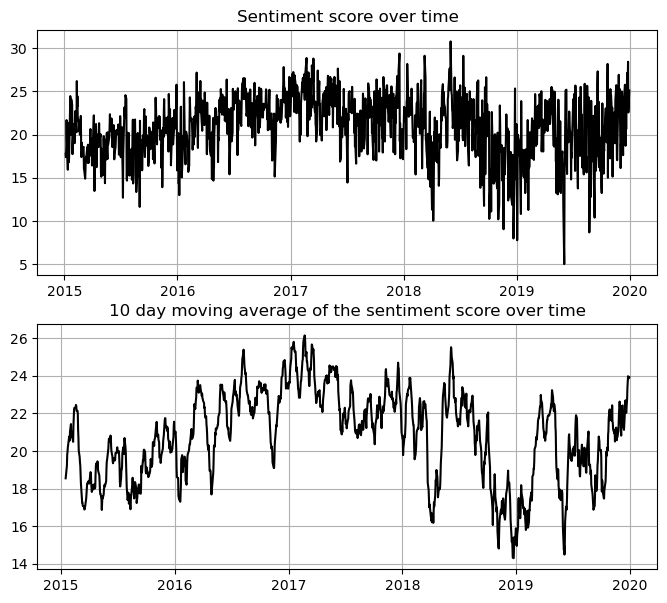

In [2]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.title('Sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['sentiment_score'], color = 'black')
plt.subplot(2,1,2)
plt.title('10 day moving average of the sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['moving_average_10day'], color = 'black')

-------------------------------------------------
### 2. Define Sharpe function

In [70]:
# Define the window size and alpha for exponential decay
window_size = 60
alpha = 1.0

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])
weights = np.flip(weights)

# Normalize weights
weights /= weights.sum()

# Define the custom function to calculate quantiles with weights
def weighted_quantile(values, quantile=0.5):
    # Ensure the values are sorted
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    # Compute the cumulative sum of weights
    cumsum = np.cumsum(weights_sorted)

    # Find where the cumulative sum equals or exceeds the quantile
    return np.interp(quantile, cumsum, values_sorted)

In [75]:
# define sharpe function with exponential decay
def overall_sharpe_sentiment_prec_exp(sentiment):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    upper = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    #test_sent = sentiment['2018-07-01':]
    for i in sentiment.index:
        score = sentiment[i]
        if score > upper[i]: 
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: 
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [76]:
# sharpes from actual data, to compare:

print('Sharpe for actual sentiment score: ', overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['sentiment_score'])[0])
print('Sharpe for actual 10 day moving average: ', overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['moving_average_10day'])[0])

Sharpe for actual sentiment score:  0.36033706012919303
Sharpe for actual 10 day moving average:  0.12360408101329981


#### based on percentiles not decaying:

In [98]:
def overall_sharpe_sentiment_precentiles(sentiment):
    w_ndq = []
    w_rf = []

    upper = portfolio_df_sent_rolling.shift(1).rolling(60).quantile(0.75)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60).quantile(0.25)
    #test_sent = sentiment['2018-01-01':]
    for i in sentiment.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

## Correct Sharpe:

In [2]:
def sharpe_correct(sentiment):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    upper = portfolio_df_sent_rolling.shift(1).rolling(63).quantile(0.66) #apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = portfolio_df_sent_rolling.shift(1).rolling(63).quantile(0.33) #apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    test_df = portfolio_df_sent_test['2018-07-01':]
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    test_df['w_ndq'] = w_ndq
    test_df['w_rf'] = w_rf
    test_df['r_portfolio'] = test_df['w_ndq'] * test_df['r_ndq'] + test_df['w_rf'] * test_df['r_rf']
    test_df['excess returns'] = test_df['r_portfolio'] - test_df['daily_rf']
    test_df['trading day'] = (test_df['w_ndq'] != test_df['w_ndq'].shift(1)).astype(int)
    
    test_df.reset_index(inplace=True)
    # Identify maximum index in the dataset
    max_index = test_df.index.max()

    # Initialize starting portfolio value
    initial_portfolio_value = 1

    # Create a new DataFrame to store calculated values
    df_calc = pd.DataFrame(index=test_df.index, columns=['portfolio_value', 'ndq_start', 'rf_start', 'ndq_end', 'rf_end'])
    
    # Initialize first values from row 0
    df_calc.loc[0, 'portfolio_value'] = initial_portfolio_value
    df_calc.loc[0, 'ndq_start'] = 0
    df_calc.loc[0, 'rf_start'] = 0
    df_calc.loc[0, 'ndq_end'] = w_ndq[0] * initial_portfolio_value
    df_calc.loc[0, 'rf_end'] = w_rf[0] * initial_portfolio_value

    # Loop through rows from 1 to max_index to calculate the required columns
    for i in range(1, max_index + 1):
        # Calculate ndq_start and rf_start
        df_calc.loc[i, 'ndq_start'] = df_calc.loc[i - 1, 'ndq_end'] * (1 + test_df.loc[i, 'r_ndq'])
        df_calc.loc[i, 'rf_start'] = df_calc.loc[i - 1, 'rf_end'] * (1 + test_df.loc[i, 'r_rf'])

        # Calculate the new portfolio value
        df_calc.loc[i, 'portfolio_value'] = df_calc.loc[i, 'ndq_start'] + df_calc.loc[i, 'rf_start']

        # Calculate ndq_end and rf_end based on updated portfolio value
        df_calc.loc[i, 'ndq_end'] =  w_ndq[i] * df_calc.loc[i, 'portfolio_value']
        df_calc.loc[i, 'rf_end'] = w_rf[i] * df_calc.loc[i, 'portfolio_value']
    
    return2019 = (df_calc['portfolio_value'][-1:]/df_calc['portfolio_value'][0]) **(1/(375/250)) - 1
    risk_free2019 = test_df['rf_rate'].mean()/100
    std2019 = np.std(test_df['excess returns'])*np.sqrt(250)

    test_df.set_index('Date', inplace=True)
    
    return (return2019 - risk_free2019)/std2019, df_calc, test_df



---------------------------------------------------------------
### 3. ARMA model

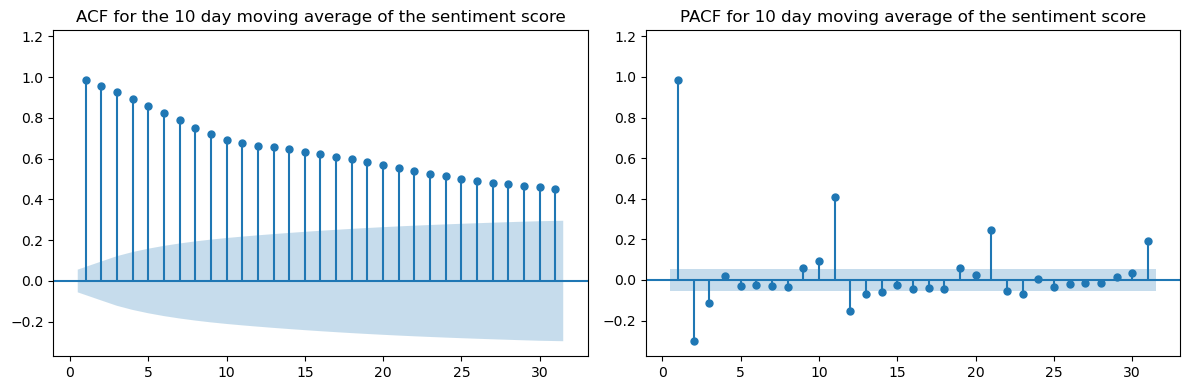

In [3]:
#Plot acf and pacf for moving average:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the 10 day moving average of the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for 10 day moving average of the sentiment score')

plt.tight_layout()
plt.show()

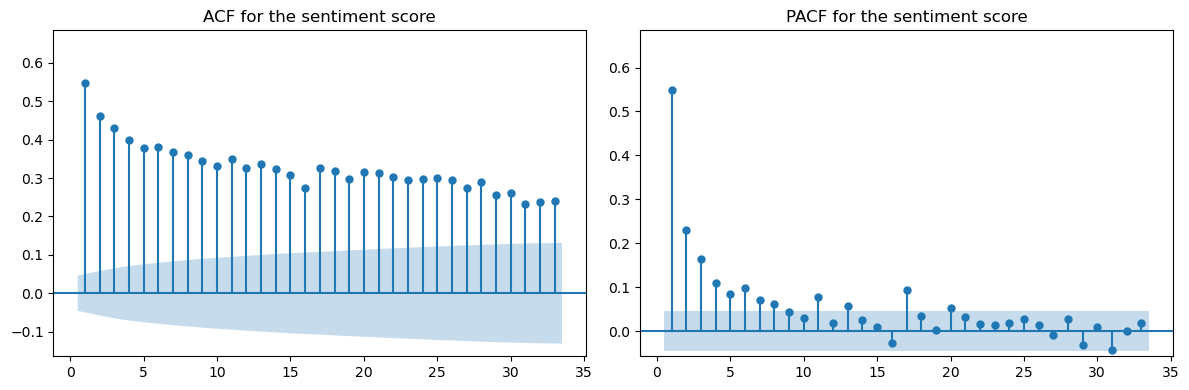

In [4]:
#Plot acf and pacf for sentiment score:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax1, title='ACF for the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax2, title='PACF for the sentiment score')

plt.tight_layout()
plt.show()


#### Model for sentiment score:

In [8]:
# use BIC and AIC to pick order - sentiment score
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 4

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (2, 2, 8853.996986993501)
Optimal lag orders based on BIC for ARMA model: (2, 1, 8884.0491508494)


In [5]:
# date as index
sentiment_index_df.set_index('Date', inplace=True)

In [6]:
# define y_train and y_test for time series stuff:
sentiment_df_train = sentiment_index_df[:'2018-07-01'].copy()
sentiment_df_test = sentiment_index_df['2018-07-01':].copy()

y_train = sentiment_df_train['sentiment_score'].copy()
y_test = sentiment_df_test['sentiment_score'].copy()

In [11]:
#Fit ARMA to the sentiment score

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list_sc = []
conf = []

#initial training and test sets:
train_data = y_train.copy() # ['sentiment_score'].copy()
test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list_sc.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list_sc))
r2 = r2_score(test_data, forecast_list_sc)
print("RMSE:", rmse, "R2:", r2)

Overall average MSE: 0.3034583383163795
RMSE: 3.398801463604458 R2: 0.2655463539265569


In [14]:
# Make the forecast a series and calculate sharpe
values = [s.iloc[0] for s in forecast_list_sc]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series_sc = pd.Series(values)
forecast_series_sc.index = test_data.index

sharpe, calc_df, test_df = sharpe_correct(forecast_series_sc[~forecast_series_sc.index.isin(forecast_series_sc.index.difference(portfolio_df_sent_test.index))])
sharpe

372    0.546582
Name: portfolio_value, dtype: object

In [16]:
test_df['trading day'].sum()

117

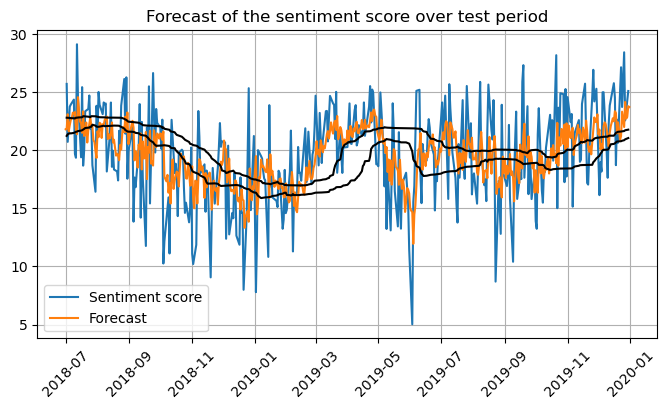

In [55]:
# visualization of forecast
plt.figure(figsize=(8,4))
plt.plot(portfolio_df_sent_test['sentiment_score'], label='Sentiment score')
plt.plot(forecast_series_sc, label = 'Forecast')
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Forecast of the sentiment score over test period')
plt.legend()
plt.show()

In [20]:
np.log(7)

1.9459101490553132

#### Model for moving average:

In [18]:
# pick the order with aic and bic
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 4

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (3, 4, 1071.383092297266)
Optimal lag orders based on BIC for ARMA model: (3, 4, 1117.474364376467)


In [19]:
# rolling window forecast with p = 3, q = 4
# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
#train_data = y_train.copy() # ['sentiment_score'].copy()
#test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()
train_data = portfolio_df_sent[:'2018-07-01']['moving_average_10day'].dropna().copy()
test_data = portfolio_df_sent['2018-07-01':]['moving_average_10day'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(3, 0, 4))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

Overall average MSE: 0.03706717893845573
RMSE: 0.4689340645311972 R2: 0.9576028000237256


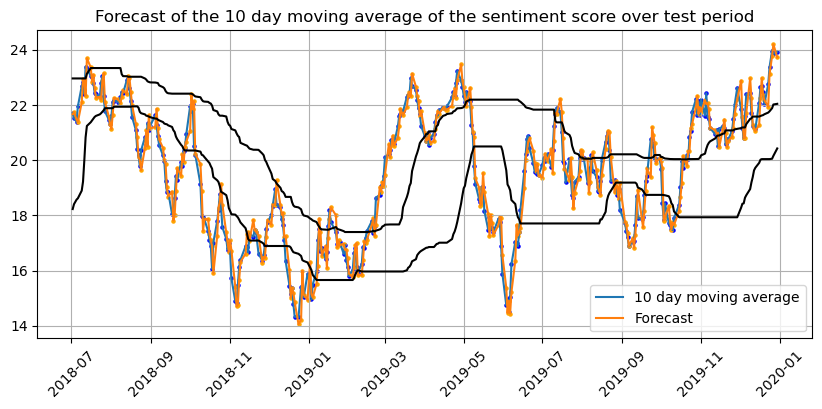

In [102]:
# visualize forecast: 
plt.figure(figsize=(10,4))
plt.plot(portfolio_df_sent_test['moving_average_10day'], label='10 day moving average')
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['moving_average_10day'], s = 5, color = 'blue')
plt.plot(portfolio_df_sent_test.index, forecast_list, label = 'Forecast')
plt.scatter(portfolio_df_sent_test.index, forecast_list, s = 5, color = 'orange')
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Forecast of the 10 day moving average of the sentiment score over test period')
plt.legend()
plt.show()

In [124]:
# make forecast a series and calculate sharpe:

# Extract numeric values from each Series in the list
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = portfolio_df_sent_test.index

sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])
sharpe

0.07769114181206138

In [125]:
portfolio_df_sent_test['trading day'].sum()

68

In [99]:
sharpe, upper, lower = overall_sharpe_sentiment_precentiles(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])

In [100]:
sharpe

0.07916726762775568

-----------------------------------------------
### 4. Machine learning models

#### Moving average:

In [104]:
# try random forest, gradient boosting and xgboost:
# for that we need the lags of the moving average:

moving_average_df = portfolio_df_sent.copy().dropna()
moving_average_df['moving_average_10day_lag'] = moving_average_df['moving_average_10day'].shift(1)
moving_average_df['volatility_lag'] = moving_average_df['Volatility'].shift(1)
moving_average_df['r_ndq_lag'] = moving_average_df['r_ndq'].shift(1)
moving_average_df['slope_lag'] = moving_average_df['sentiment_slope'].shift(1)
moving_average_df = moving_average_df.dropna()

X_train_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag' ]][:'2018-07-01']
X_test_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag']]['2018-07-01':]
y_train_ma = moving_average_df['moving_average_10day'][:'2018-07-01']
y_test_ma = moving_average_df['moving_average_10day']['2018-07-01':]

In [105]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf' : 5}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.1111111111111111}
}

# Assuming y_test, X_train2, X_test2, y_train are defined somewhere here

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 864

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test_ma.copy()
    #print(actuals.head())

    # Start rolling window forecast
    for i in range(len(X_test_ma)):
        #start and end of rolling window:
        start_point = max(0, len(X_train_ma) + i - window_size)
        end_point = len(X_train_ma) + i
        #print(start_point, end_point)

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_ma).iloc[i:], pd.DataFrame(X_test_ma).iloc[:i]])
        y_train_rolling = pd.concat([y_train_ma, y_test_ma.iloc[:i]]).iloc[start_point:end_point]
        #print(X_train_rolling.shape)

        # Scale x train:
        scaler = StandardScaler()
        X_train_rolling_scaled = scaler.fit_transform(X_train_rolling)
        X_train_rolling_scaled_df = pd.DataFrame(X_train_rolling_scaled, columns = X_train_rolling.columns)
        model.set_params(**params)
        model.fit(X_train_rolling_scaled_df, y_train_rolling)
        
        # Scale x test for the current point:
        X_test_scaled = scaler.transform(X_test_ma.iloc[[i]])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_ma.columns)
    
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_scaled_df)
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 0.5445844473402666, 'R2': 0.942820009365397}, 'Gradient Boosting': {'RMSE': 0.5359962567199212, 'R2': 0.9446092654169449}}


In [126]:
# Create a new Series from the list of values
rf_pred = pd.Series(model_predictions2['Random Forest']['y_pred'])
rf_pred.index = portfolio_df_sent_test.index

sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(rf_pred)
sharpe

0.07103778204501345

In [127]:
portfolio_df_sent_test['trading day'].sum()

54

In [110]:
overall_sharpe_sentiment_precentiles(rf_pred)[0]

0.07406809683557365

In [128]:
# Create a new Series from the list of values
gb_pred = pd.Series(model_predictions2['Gradient Boosting']['y_pred'])
gb_pred.index = portfolio_df_sent_test.index

sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(gb_pred)
sharpe

0.07857887343883568

In [129]:
portfolio_df_sent_test['trading day'].sum()

50

In [113]:
overall_sharpe_sentiment_precentiles(gb_pred)[0]

0.07424322431178275

----------------------
gradient boosting cross validation:
{'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.1111111111111111}

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
# Define the parameter grid
gb_param_grid = {
    'n_estimators': range(80,90),
    'max_depth': [1, 2, 3],
    #'min_samples_leaf': [1, 5, 6],
    'learning_rate': np.linspace(0.01, 0.15,20)
}

# Setup the grid search
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train_ma, y_train_ma)

# Best model
gb_best_model = gb_grid_search.best_estimator_
print("Best parameters:", gb_grid_search.best_params_)
pred = gb_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction_gb = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

Best parameters: {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 87}
0.9167186090892239


--------------------------------------------------
### 5. Classification models?